In [1]:
import numpy as np
import astropy as ast
import matplotlib.pyplot as plt

from astropy import units as u

In [2]:
def get_phi(vector: np.ndarray) -> float:
    """Return the azimuthal angle of vector (in conventional spherical coordinates).
    """
    
    if vector[0] > 0:
        return np.arctan(vector[1] / vector[0])
    elif vector[0] < 0 :
        return np.arctan(vector[1] / vector[0]) + np.pi
    else:
        if vector[1] > 0:
            return np.pi / 2
        elif vector[1] < 0:
            return -np.pi / 2
        else:
            return 0

In [3]:
def get_theta(vector: np.ndarray) -> float:
    """Return the polar angle of vector (in conventional spherical coordinates).
    """
    
    rho = np.sqrt(np.sum(vector ** 2))
    
    if rho != 0:
        return np.arccos(vector[2] / rho)
    else:
        return np.pi / 2

In [4]:
def build_triple_rotation_matrix(ref_r: np.ndarray, ref_L: np.ndarray) -> np.ndarray:
    """Return a matrix object to transform vectors to from an original coordinate system
    to a coordinate system where (x = ref_r, y = 0, z = 0) and z points along ref_L.
    """
    
    # get the angles of spherical coordinates of ref_r
    phi = get_phi(ref_r)
    theta = get_theta(ref_r)
    
    # rotation 1 rotates around z-axis 
    rotation_1 = np.zeros([3, 3])
    
    rotation_1[0][0] = np.cos(phi)
    rotation_1[0][1] = np.sin(phi)
    rotation_1[1][0] = -np.sin(phi)
    rotation_1[1][1] = np.cos(phi)
    rotation_1[2][2] = 1
    
    # rotation 2 rotates around new y-axis
    rotation_2 = np.zeros([3, 3])
    
    rotation_2[0][0] = np.sin(theta)
    rotation_2[0][2] = np.cos(theta)
    rotation_2[2][0] = -np.cos(theta)
    rotation_2[2][2] = np.sin(theta)
    rotation_2[1][1] = 1
    
    double_rotation = rotation_2 @ rotation_1
    
    # rotate ref_L by rotation_1 then rotation_2
    interm_L = double_rotation @ ref_L
    
    # rearrange components of interm_L to get azimuthal angle w.r.t. x instead of z
    pseudo_L = np.array([
        interm_L[1],
        interm_L[2],
        interm_L[0]
    ])
    
    pseudo_phi = get_phi(pseudo_L)
    
    # rotation_3 rotates around new x-axis
    rotation_3 = np.zeros([3, 3])
    
    rotation_3[0][0] = 1
    rotation_3[1][1] = np.sin(pseudo_phi)
    rotation_3[1][2] = -np.cos(pseudo_phi)
    rotation_3[2][1] = np.cos(pseudo_phi)
    rotation_3[2][2] = np.sin(pseudo_phi)
    
    return rotation_3 @ double_rotation

In [5]:
def n_sigma_clipping(max_longitude_rad: float, longitudes_rad: np.ndarray, values: np.ndarray,
                     w: float, max_value: float, min_value: float, n: float) -> tuple:
    """Return the list of longitudes (in degrees) between -max_longitude_rad and max_longitude_rad where 
    there are stars within +/- w degrees and their angular moment is between min_value and max_value and the 
    list of average angular momentum in each of those ranges and the list of standard deviations in angular 
    momentum in each of those ranges, given a star cluster's longitudes_rad and values, both recalculated after 
    excluding values greater than n original standard deviations.
    """

    degs = []
    avg_delta_Lz = []
    std_delta_Lz = []

    for deg in np.arange(-max_longitude_rad * u.rad.to(u.deg), max_longitude_rad * u.rad.to(u.deg) + 1):

        delta_Lz_list = []

        for star in range(len(longitudes_rad)):

            if deg - w <= longitudes_rad[star] * u.rad.to(u.deg) < deg + w\
            and min_value <= values[star] <= max_value:
                delta_Lz_list.append(values[star])

        if delta_Lz_list != []:

            mean = np.mean(delta_Lz_list)
            sigma = np.std(delta_Lz_list)
            
            new_delta_Lz_list = []
            
            for v in delta_Lz_list:
                if abs(v - mean) <= n * sigma:
                    new_delta_Lz_list.append(v)
                    
            if new_delta_Lz_list != []:
                degs.append(deg)
                avg_delta_Lz.append(np.mean(new_delta_Lz_list))
                std_delta_Lz.append(np.std(new_delta_Lz_list))
            
    return(np.array(degs), avg_delta_Lz, std_delta_Lz)

In [6]:
# Fixed constants

dir = '/data/vxtest/519'
adjust = 80

In [7]:
# Modifiable constants

cluster = 268

tenMy_start = 1150
tenMy_end = 1200
snap_interval = 1

tout_ref = 930
max_t_since_out = 0.4

halo_mass_threshold = 1e7
distance_threshold_for_plot = 15

In [8]:
# Prepare dictionary d containing dictionaries d[snap]

snap_start = tenMy_start - adjust
snap_end = tenMy_end - adjust

snaps = np.arange(snap_start, snap_end + 1, snap_interval)

d = {}

for t in snaps:
    d[str(t)] = {}

In [9]:
# Fill all dictionaries d[snap]

for snap in d:

    mainfile = dir + '/snapshot_' + snap.zfill(4)
    halofile = dir + '/halos/h' + snap + '.z0.000.AHF_halos'

    hd = np.fromfile(mainfile,dtype='int32',count=7)
    d[snap]['nd'] = hd[2]
    d[snap]['ns'] = hd[5]
    d[snap]['nc'] = hd[3]
    d[snap]['nb'] = hd[4]
    
    head = np.fromfile(mainfile,dtype='double',count=7,offset=4+6*4)
    d[snap]['time'] = head[6]
    
    start_d = 0
    start_c = d[snap]['nd']
    start_b = d[snap]['nd'] + d[snap]['nc']
    start_s = d[snap]['nd'] + d[snap]['nc'] + d[snap]['nb']
    block = d[snap]['nd'] + d[snap]['nc'] + d[snap]['ns'] + d[snap]['nb']

    if d[snap]['nb'] > 0:
        skipx = 256 + 3*4 + start_b*3*8
        skipv = 256 + 5*4 + (block*3 + start_b*3)*8
        d[snap]['rc'] = np.fromfile(mainfile,dtype='double',count=3,offset=skipx)
        d[snap]['vc'] = np.fromfile(mainfile,dtype='double',count=3,offset=skipv)
        d[snap]['xh'] = d[snap]['rc'][0]
        d[snap]['yh'] = d[snap]['rc'][1]
        d[snap]['zh'] = d[snap]['rc'][2]
        d[snap]['vxh'] = d[snap]['vc'][0]
        d[snap]['vyh'] = d[snap]['vc'][1]
        d[snap]['vzh'] = d[snap]['vc'][2]
    
    skipx = 256 + 3*4 + start_c*3*8
    skipv = 256 + 5*4 + (block*3 + start_c*3)*8
    skipi = 256 + 7*4 + block*3*2*8 + start_c*4
    d[snap]['rc'] = np.fromfile(mainfile, dtype='double', count=3*d[snap]['nc'], offset=skipx)
    d[snap]['vc'] = np.fromfile(mainfile, dtype='double', count=3*d[snap]['nc'], offset=skipv)
    d[snap]['idc'] = np.fromfile(mainfile, dtype='uint32', count=d[snap]['nc'], offset=skipi)
    d[snap]['jxc'] = d[snap]['rc'][0::3] - d[snap]['xh']
    d[snap]['jyc'] = d[snap]['rc'][1::3] - d[snap]['yh']
    d[snap]['jzc'] = d[snap]['rc'][2::3] - d[snap]['zh']

    d[snap]['jvxc'] = d[snap]['vc'][0::3] - d[snap]['vxh']
    d[snap]['jvyc'] = d[snap]['vc'][1::3] - d[snap]['vyh']
    d[snap]['jvzc'] = d[snap]['vc'][2::3] - d[snap]['vzh']

    d[snap]['idc'] -= d[snap]['nd']
    ki = np.zeros(d[snap]['nc'], dtype='int32')
    for j in range(d[snap]['nc']):
        ix = d[snap]['idc'][j]
        ki[ix] = j

    d[snap]['xc'] = d[snap]['jxc'][ki]
    d[snap]['yc'] = d[snap]['jyc'][ki]
    d[snap]['zc'] = d[snap]['jzc'][ki]

    d[snap]['vxc'] = d[snap]['jvxc'][ki]
    d[snap]['vyc'] = d[snap]['jvyc'][ki]
    d[snap]['vzc'] = d[snap]['jvzc'][ki]

    d[snap]['rh3'] = [d[snap]['xh'], d[snap]['yh'], d[snap]['zh']]
    d[snap]['vh3'] = [d[snap]['vxh'], d[snap]['vyh'], d[snap]['vzh']]
    
    #centers unsorted
    d[snap]['jrc3'] = np.reshape(d[snap]['rc'], (d[snap]['nc'], 3)) - d[snap]['rh3']
    d[snap]['jvc3'] = np.reshape(d[snap]['vc'],(d[snap]['nc'], 3)) - d[snap]['vh3']
 
    d[snap]['rc3'] = d[snap]['jrc3'][ki]
    d[snap]['vc3'] = d[snap]['jvc3'][ki]
 
    skipx = 256 + 3*4 + start_s*3*8
    skipv = 256 + 5*4 + block*3*8 + start_s*3*8 #skip over r, and dm+c v's
    skipi = 256 + 7*4 + block*3*2*8 + start_s*4 #skip over r and v and dm+c id
    skipc = 256 + 9*4 + block*(2*3*8+4) + start_s*4 #skip over r, v and id and dm+c ic

    d[snap]['rs'] = np.fromfile(mainfile, dtype='double', count=3*d[snap]['ns'], offset=skipx)
    d[snap]['vs'] = np.fromfile(mainfile, dtype='double', count=3*d[snap]['ns'], offset=skipv)
    d[snap]['ids'] = np.fromfile(mainfile, dtype='uint32', count=d[snap]['ns'], offset=skipi)
    d[snap]['jics'] = np.fromfile(mainfile,dtype='uint32',count=d[snap]['ns'],offset=skipc)

    d[snap]['jrs3'] = np.reshape(d[snap]['rs'], (d[snap]['ns'], 3)) - d[snap]['rh3']
    d[snap]['jvs3'] = np.reshape(d[snap]['vs'], (d[snap]['ns'], 3)) - d[snap]['vh3']
 
    d[snap]['ids'] -= d[snap]['nd'] + d[snap]['nc'] + d[snap]['nb']
    ki = np.zeros(d[snap]['ns'], dtype='int32')
    for j in range(d[snap]['ns']):
        ix = d[snap]['ids'][j]
        ki[ix] = j

    d[snap]['rs3'] = d[snap]['jrs3'][ki]
    d[snap]['vs3'] = d[snap]['jvs3'][ki]
    d[snap]['ics'] = d[snap]['jics'][ki]

    # there is a change in shape vs the previous method;  
    # adapt to select the right array axis instead of skip by 3 along a single 1-d
    
    d[snap]['xs'] = d[snap]['rs3'][:,0]
    d[snap]['ys'] = d[snap]['rs3'][:,1]
    d[snap]['zs'] = d[snap]['rs3'][:,2]
    d[snap]['vxs'] = d[snap]['vs3'][:,0]
    d[snap]['vys'] = d[snap]['vs3'][:,1]
    d[snap]['vzs'] = d[snap]['vs3'][:,2]
    
    # distance from centre of galaxy
    d[snap]['ds'] = np.sqrt(d[snap]['xs'] ** 2 + d[snap]['ys'] ** 2 + d[snap]['zs'] ** 2)
    

    dh = np.loadtxt(halofile)
    
    d[snap]['halom'] = dh[:,3] #halo mass. The file also has various radii and velocities
    d[snap]['hx'] = dh[:,5]
    d[snap]['hy'] = dh[:,6]
    d[snap]['hz'] = dh[:,7]
    d[snap]['hvx'] = dh[:,8]
    d[snap]['hvy'] = dh[:,9]
    d[snap]['hvz'] = dh[:,10]
    d[snap]['halor'] = dh[:,12]


    #need to use the same xh, vxh etc for the center of mass as used for the stars
    d[snap]['halox'] = d[snap]['hx'] - d[snap]['xh']
    d[snap]['haloy'] = d[snap]['hy'] - d[snap]['yh']
    d[snap]['haloz'] = d[snap]['hz'] - d[snap]['zh']
    d[snap]['halovx'] = d[snap]['hvx'] - d[snap]['vxh']
    d[snap]['halovy'] = d[snap]['hvy'] - d[snap]['vyh']
    d[snap]['halovz'] = d[snap]['hvz'] - d[snap]['vzh']

In [10]:
toutfile = dir + '/TOUT' + str(tout_ref).zfill(4)

# thead = np.fromfile(toutfile, dtype='double', count=1)
# Tend = thead[0] # = 10.1
# Toffset = 14.1 - Tend # = 4

nnn = np.fromfile(toutfile, dtype='int32', count=3, offset=8)
ntc = nnn[1]

# nstart = nnn[0]
# nts = nnn[2]

noff = 8 + (3 * 4)

outid = []
t_since_out = []

for c in range(ntc):
    
    readout_c = np.fromfile(toutfile, dtype='int32', count=1, offset=noff)
    newcount = readout_c[0]
    noff += 4
    
    readout_n = np.fromfile(toutfile, dtype='int32', count=newcount, offset=noff)
    outid.append(readout_n)
    noff += 4 * newcount
    
    readout_t = np.fromfile(toutfile, dtype='double', count=newcount, offset=noff)
    t_since_out.append(readout_t)
    noff += 8 * newcount

recently_out = t_since_out[cluster] < max_t_since_out

In [11]:
cluster_d = {}

for t in snaps:
    cluster_d[str(t)] = {}

for snap in cluster_d:
    
    # I think this reorders and selects only the cluster
    cluster_d[snap]['out_x'] = d[snap]['rs3'][outid[cluster], 0]
    cluster_d[snap]['out_y'] = d[snap]['rs3'][outid[cluster], 1]
    cluster_d[snap]['out_z'] = d[snap]['rs3'][outid[cluster], 2]

    # Median of out_x,y,z only if recently out
    cluster_d[snap]['out_x_median'] = np.median(cluster_d[snap]['out_x'][recently_out])
    cluster_d[snap]['out_y_median'] = np.median(cluster_d[snap]['out_y'][recently_out])
    cluster_d[snap]['out_z_median'] = np.median(cluster_d[snap]['out_z'][recently_out])

In [12]:
distances_sorted_by_t = []
times_sorted_by_t = []
masses_sorted_by_t = []

for snap in cluster_d:

    distances = []
    times = []
    masses = []
    
    t = d[snap]['time']

    for i in range(len(d[snap]['halom'])):
        
        mass = d[snap]['halom'][i]
    
        if mass >= halo_mass_threshold:
            
            delta_x = d[snap]['halox'][i] - cluster_d[snap]['out_x_median']
            delta_y = d[snap]['haloy'][i] - cluster_d[snap]['out_y_median']
            delta_z = d[snap]['haloz'][i] - cluster_d[snap]['out_z_median']
            
            dist = np.sqrt(delta_x ** 2 + delta_y ** 2 + delta_z ** 2)
            
            distances.append(dist)
            times.append(t)
            masses.append(mass)           
        
    distances_sorted_by_t.append(distances)
    times_sorted_by_t.append(times)
    masses_sorted_by_t.append(masses)

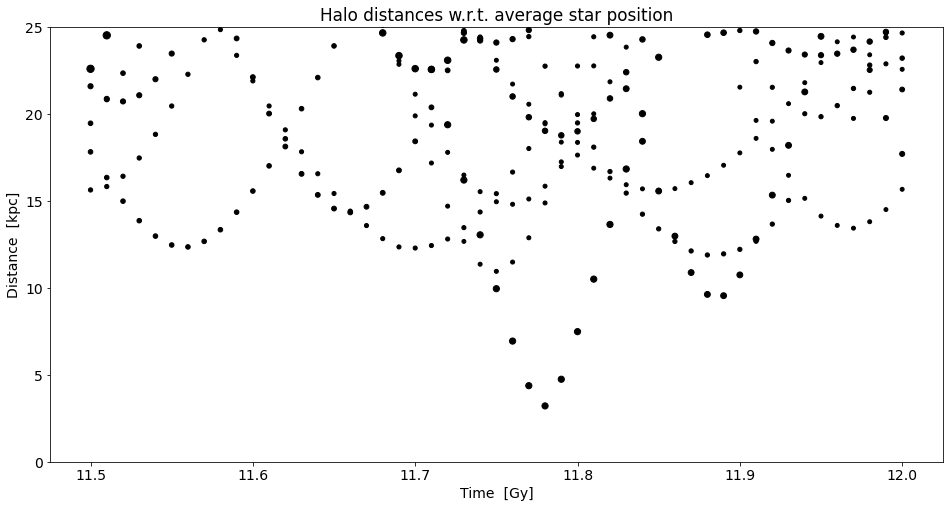

In [13]:
plt.figure(figsize=(16, 8))
plt.rc('font', size=14)

for i in range(len(distances_sorted_by_t)):
    sizes = 15 * (np.log10(masses_sorted_by_t[i]) - 6)
    plt.scatter(times_sorted_by_t[i], distances_sorted_by_t[i], c='k', s=sizes)

plt.ylim(0, 25)

plt.xlabel('Time  [Gy]')
plt.ylabel('Distance  [kpc]')
plt.title('Halo distances w.r.t. average star position')

plt.show()

In [15]:
zoom = 4
dg = 1/90

lon_max = np.pi / zoom
lat_max = np.pi / 3 / zoom

ng_lon = int(2 * lon_max / dg + 1) 
ng_lat = int(2 * lat_max / dg + 1)

lon = np.linspace(-lon_max, lon_max, ng_lon + 1) 
lat = np.linspace(-lat_max, lat_max, ng_lat + 1) 
lon_v, lat_v = np.meshgrid(lon, lat)

In [16]:
lon_range_deg = np.arange(-40, 50, 10)
lon_range_deg_str = []

for deg in lon_range_deg:
    s = str(deg) + r'$^{\circ}$'
    lon_range_deg_str.append(s)
    
    
lat_range_deg = np.arange(-15, 20, 5)
lat_range_deg_str = []

for deg in lat_range_deg:
    s = str(deg) + r'$^{\circ}$'
    lat_range_deg_str.append(s)

In [45]:
# for t in sorted(d.keys(), reverse=False):

#     select = (d[t]['ics'] == cluster)

#     cluster_x = d[t]['xc'][cluster]
#     cluster_y = d[t]['yc'][cluster]
#     cluster_z = d[t]['zc'][cluster]
#     cluster_r = np.array([cluster_x, cluster_y, cluster_z])

#     cluster_vx = d[t]['vxc'][cluster]
#     cluster_vy = d[t]['vyc'][cluster]
#     cluster_vz = d[t]['vzc'][cluster]
#     cluster_v = np.array([cluster_vx, cluster_vy, cluster_vz])

#     cluster_L = np.cross(cluster_r, cluster_v)

#     transform = build_triple_rotation_matrix(ref_r=cluster_r, ref_L=cluster_L)

#     new_cluster_r = transform @ cluster_r
#     new_cluster_L = transform @ cluster_L

#     new_cluster_Lx = new_cluster_L[0]
#     new_cluster_Ly = new_cluster_L[1]
#     new_cluster_Lz = new_cluster_L[2]

#     ####
#     stars_d = d[t]['ds'][select]
#     ####

#     stars_x = d[t]['xs'][select]
#     stars_y = d[t]['ys'][select]
#     stars_z = d[t]['zs'][select]

#     stars_vx = d[t]['vxs'][select]
#     stars_vy = d[t]['vys'][select]
#     stars_vz = d[t]['vzs'][select]

#     new_stars_Lx = []
#     new_stars_Ly = []
#     new_stars_Lz = []

#     new_stars_x = []
#     new_stars_y = []
#     new_stars_z = []

#     for i in range(len(stars_x)):

#         star_x = stars_x[i]
#         star_y = stars_y[i]
#         star_z = stars_z[i]
#         star_r = [star_x, star_y, star_z]

#         star_vx = stars_vx[i]
#         star_vy = stars_vy[i]
#         star_vz = stars_vz[i]
#         star_v = [star_vx, star_vy, star_vz]

#         star_L = np.cross(star_r, star_v)
#         new_star_L = transform @ star_L

#         new_stars_Lx.append(new_star_L[0])
#         new_stars_Ly.append(new_star_L[1])
#         new_stars_Lz.append(new_star_L[2])

#         new_star_r = transform @ star_r

#         new_stars_x.append(new_star_r[0])
#         new_stars_y.append(new_star_r[1])
#         new_stars_z.append(new_star_r[2])

#     new_stars_Lx = np.array(new_stars_Lx)
#     new_stars_Ly = np.array(new_stars_Ly)
#     new_stars_Lz = np.array(new_stars_Lz)

#     new_stars_x = np.array(new_stars_x)
#     new_stars_y = np.array(new_stars_y)
#     new_stars_z = np.array(new_stars_z)

#     new_stars_delta_Lx = new_stars_Lx - new_cluster_Lx
#     new_stars_delta_Ly = new_stars_Ly - new_cluster_Ly
#     new_stars_delta_Lz = new_stars_Lz - new_cluster_Lz

#     new_stars_L_perp = np.sqrt((new_stars_delta_Lx) ** 2 + (new_stars_delta_Ly) ** 2)

#     new_stars_rho = np.sqrt(new_stars_x ** 2 + new_stars_y ** 2 + new_stars_z ** 2)

#     # longs and lats formulae taken from previous notebook
#     stars_longitudes = np.arctan2(new_stars_y, new_stars_x)
#     stars_latitudes = np.arcsin(new_stars_z / new_stars_rho)

    
#     new_halos_x = []
#     new_halos_y = []
#     new_halos_z = []
    
#     for i in range(len(d[t]['halom'])):

#         mass = d[t]['halom'][i]

#         if mass >= halo_mass_threshold:

#             delta_x = d[t]['halox'][i] - cluster_d[t]['out_x_median']
#             delta_y = d[t]['haloy'][i] - cluster_d[t]['out_y_median']
#             delta_z = d[t]['haloz'][i] - cluster_d[t]['out_z_median']

#             dist = np.sqrt(delta_x ** 2 + delta_y ** 2 + delta_z ** 2)

#             if dist <= distance_threshold_for_plot:
                
#                 halo_x = d[t]['halox'][i]
#                 halo_y = d[t]['haloy'][i]
#                 halo_z = d[t]['haloz'][i]

#                 halo_r = np.array([halo_x, halo_y, halo_z])

#                 new_halo_r = transform @ halo_r
                
#                 new_halos_x.append(new_halo_r[0])
#                 new_halos_y.append(new_halo_r[1])
#                 new_halos_z.append(new_halo_r[2])
    
#     new_halos_x = np.array(new_halos_x)
#     new_halos_y = np.array(new_halos_y)
#     new_halos_z = np.array(new_halos_z)
    
#     new_halos_rho = np.sqrt(new_halos_x ** 2 + new_halos_y ** 2 + new_halos_z ** 2)

#     halos_longitudes = np.arctan2(new_halos_y, new_halos_x)
#     halos_latitudes = np.arcsin(new_halos_z / new_halos_rho)
    
    
    
#     plt.figure(figsize=(15, 5))
#     plt.rc('font', size=14)


#     lon_v, lat_v = np.meshgrid(lon, lat)

#     D = np.zeros((ng_lat + 1, ng_lon + 1))

#     for star in range(len(stars_longitudes)):

#         if (-lon_max <= stars_longitudes[star] <= lon_max) and (-lat_max <= stars_latitudes[star] <= lat_max):

#             ix = int(round((stars_longitudes[star] + lon_max) / dg)) 
#             iy = int(round((stars_latitudes[star] + lat_max) / dg)) 
#             D[iy, ix] += 1

#     Ds = np.sqrt(D)

#     plt.subplot(1,2,1)
#     plt.pcolormesh(lon_v, lat_v, Ds, cmap='binary', vmin=1, vmax=2)
#     plt.scatter(stars_longitudes, stars_latitudes, s=8, c='orangered', alpha=0.12)
#     plt.scatter(halos_longitudes, halos_latitudes, s=100, c='limegreen', alpha=0.9, 
#                 label='nearby dark matter subhalo')

#     plt.xlim(-lon_max, lon_max)
#     plt.ylim(-17 * u.deg.to(u.rad), 17 * u.deg.to(u.rad))

#     plt.xticks(ticks=lon_range_deg * u.deg.to(u.rad), labels=lon_range_deg_str)
#     plt.yticks(ticks=lat_range_deg * u.deg.to(u.rad), labels=lat_range_deg_str)
    
#     plt.legend()

#     plt.xlabel('Galactic longitude')
#     plt.ylabel('Galactic latitude')
#     plt.title('Position in galactocentric coordinates')


#     ###
#     #d_max = max(stars_d) #/ zoom
#     d_max = 100
#     d_min = 0
#     ng_d = int((d_max - d_min) * 1 + 1)

#     d_linspace = np.linspace(d_min, d_max, ng_d + 1) 
#     lon_v, d_v = np.meshgrid(lon, d_linspace)

#     D = np.zeros((ng_d + 1, ng_lon + 1))

#     for star in range(len(stars_longitudes)):

#         if (-lon_max <= stars_longitudes[star] <= lon_max) \
#     and (d_min <= stars_d[star] <= d_max):

#             ix = int(round((stars_longitudes[star] + lon_max) / dg)) 
#             iy = int(round((stars_d[star] + -d_min) * 1)) 

#             D[iy, ix] += 1

#     Ds = np.sqrt(D)
#     ###

#     plt.subplot(1,2,2)
#     plt.pcolormesh(lon_v, d_v, Ds, cmap='binary', vmin=0, vmax=2)
#     plt.scatter(halos_longitudes, new_halos_rho, s=100, c='limegreen', alpha=0.9, 
#             label='nearby dark matter subhalo')

#     plt.xticks(ticks=lon_range_deg * u.deg.to(u.rad), labels=lon_range_deg_str)

#     plt.legend()
    
#     plt.xlabel('Galactic longitude')
#     plt.ylabel('Distance  [kpc]')
#     plt.title('Distance from galactic centre')

    
#     timestamp = d[t]['time']
    
#     plt.suptitle('Stars of cluster ' + str(cluster) + ' ' * 6 + 'n_stars = ' + str(len(stars_x))
#                  + ' ' * 6 + 'time = %.2f Gy' % timestamp, fontweight='bold')
#     plt.show()

# print('\n\n')

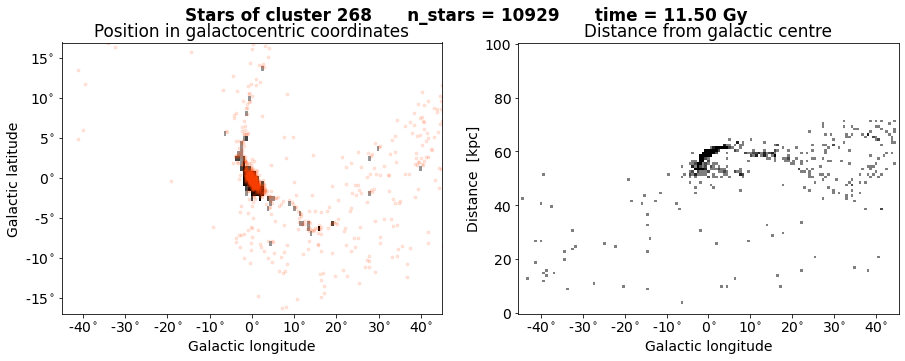

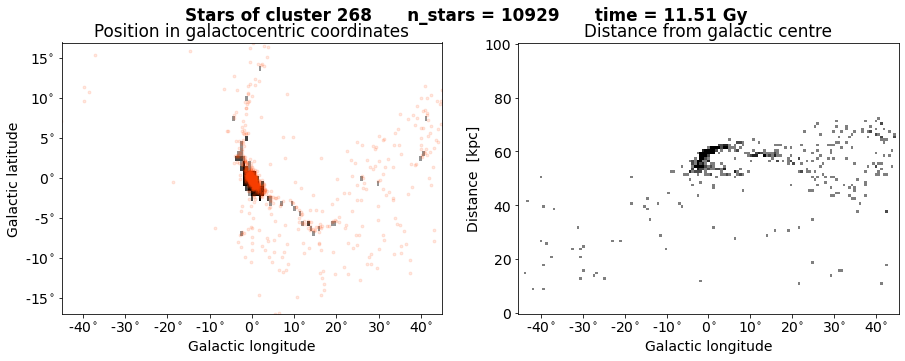

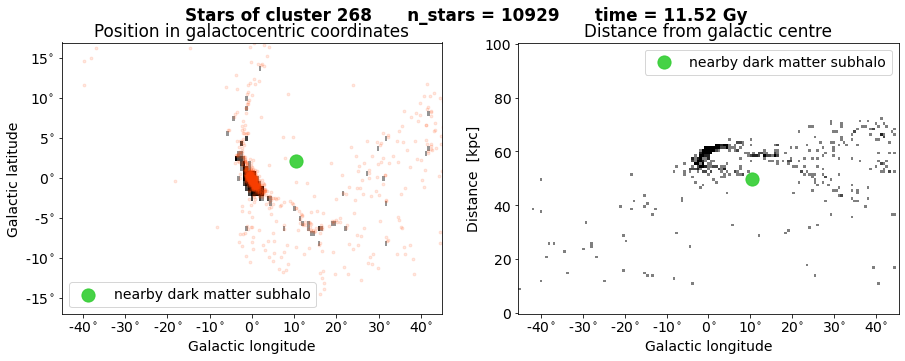

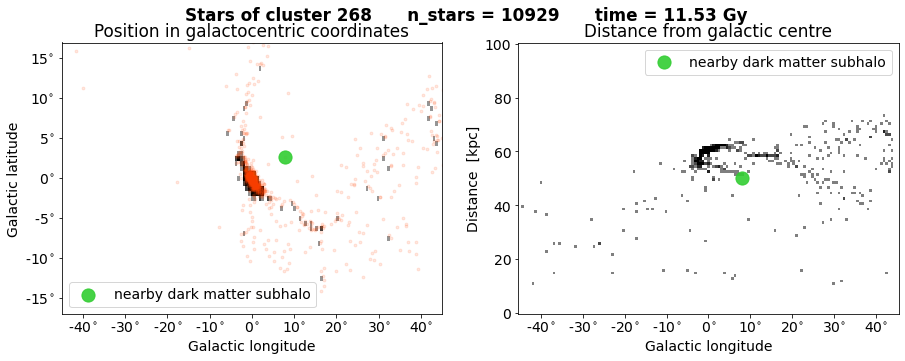

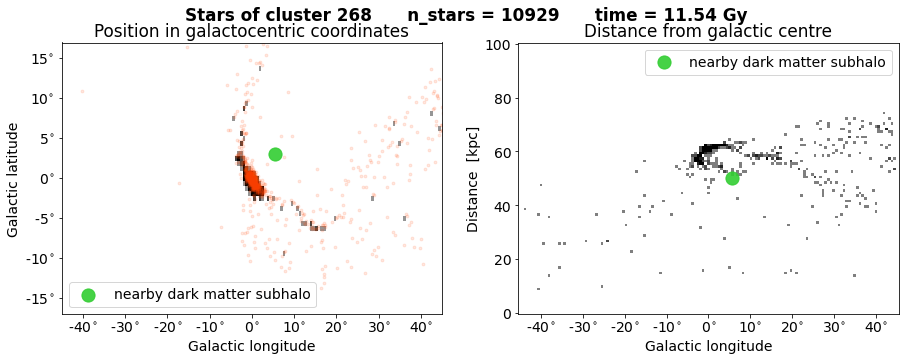

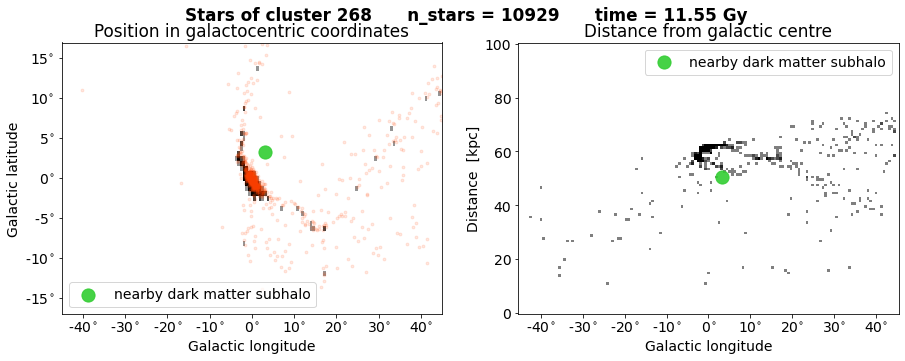

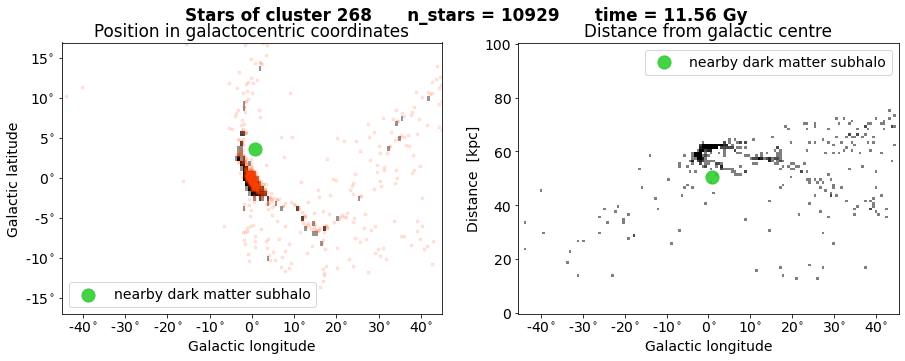

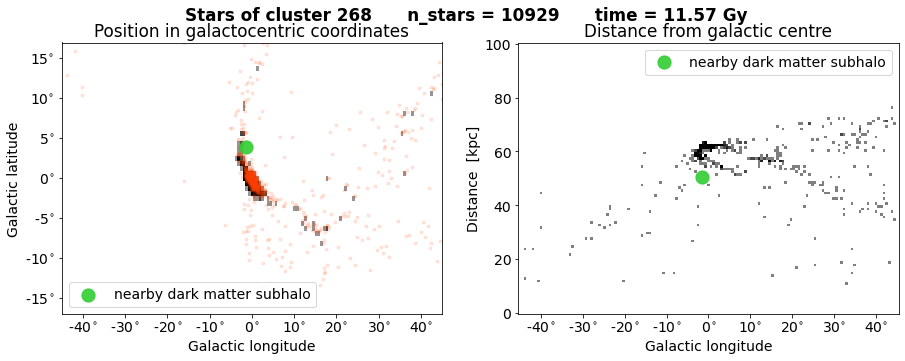

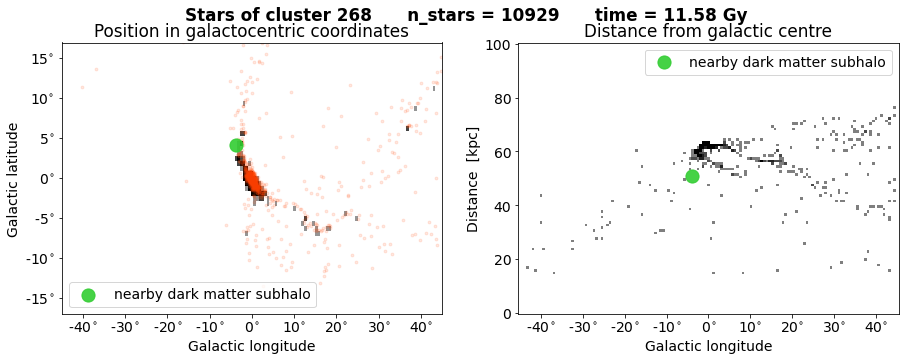

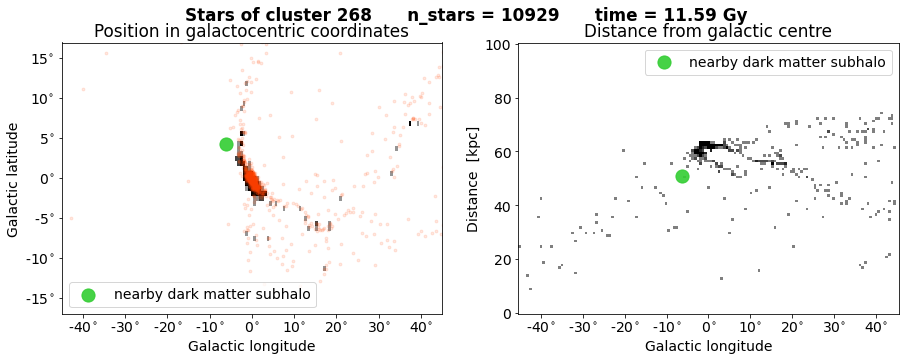

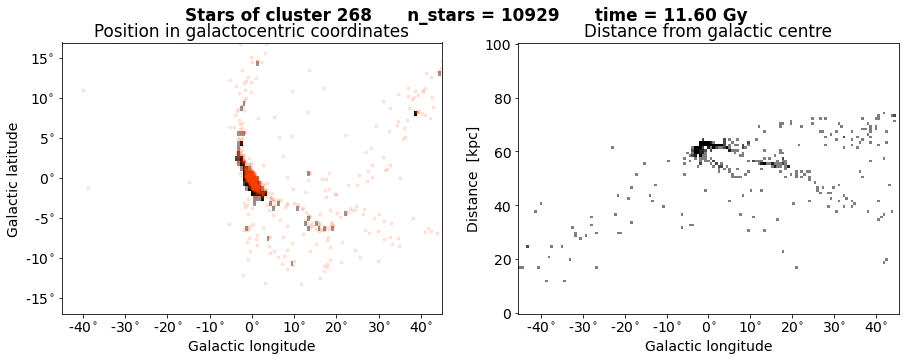

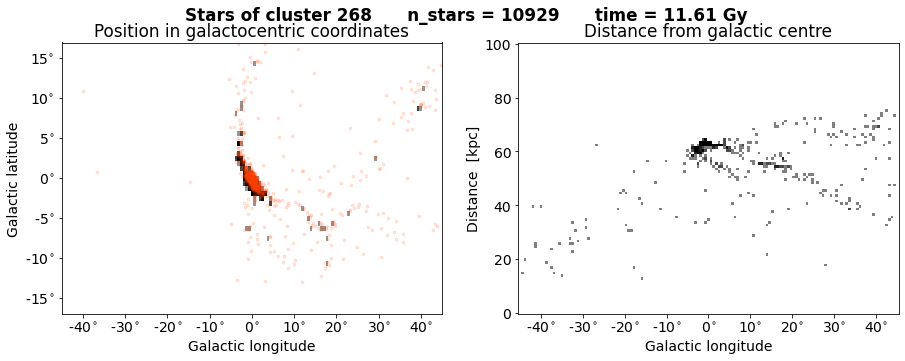

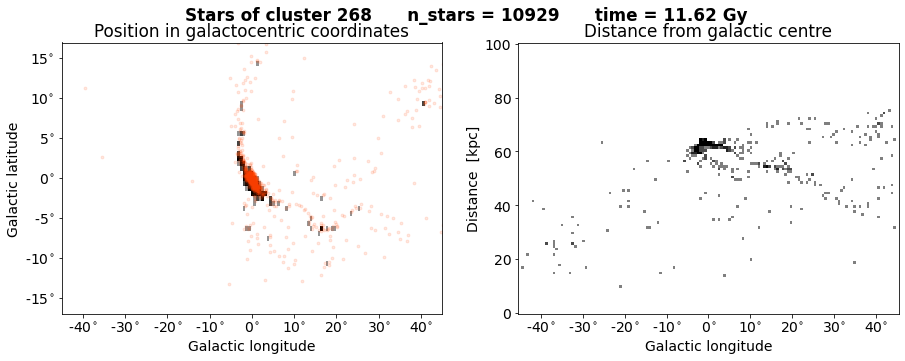

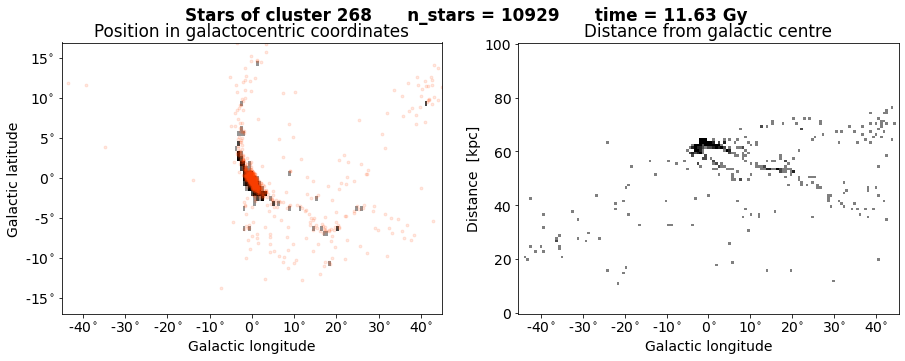

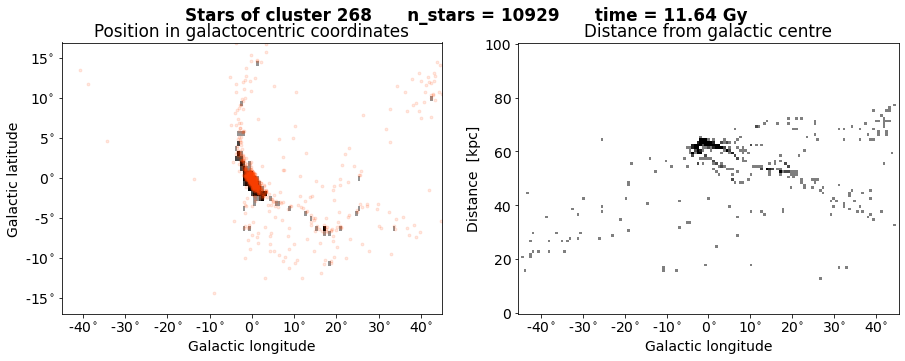

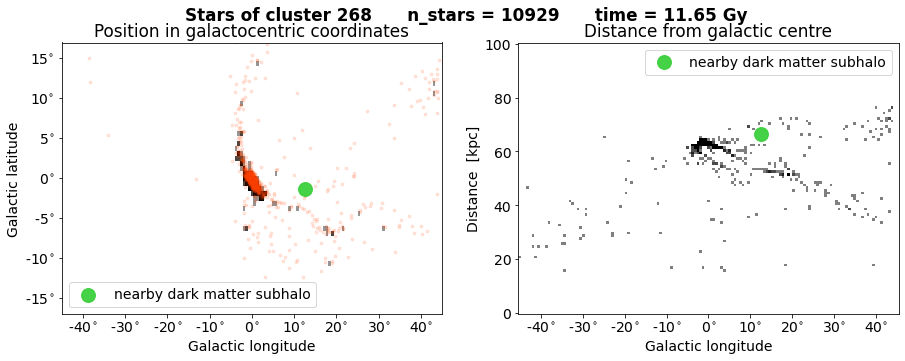

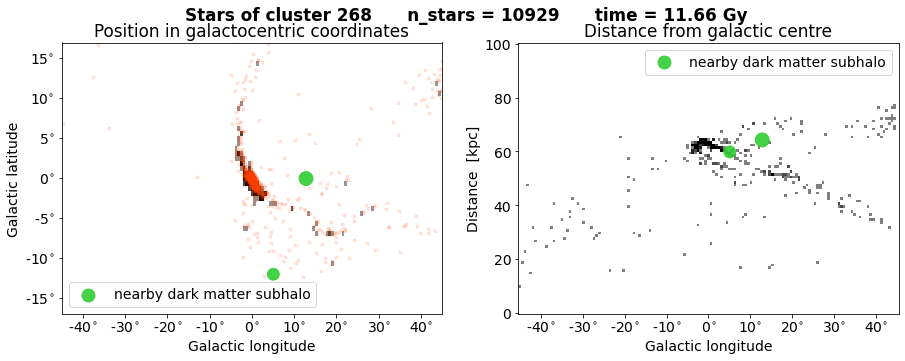

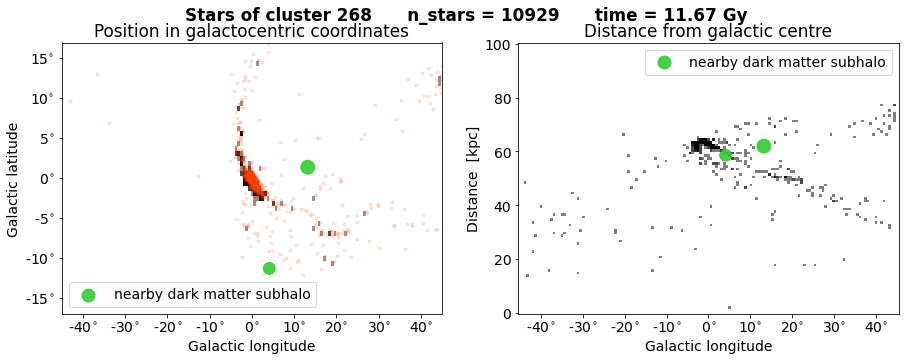

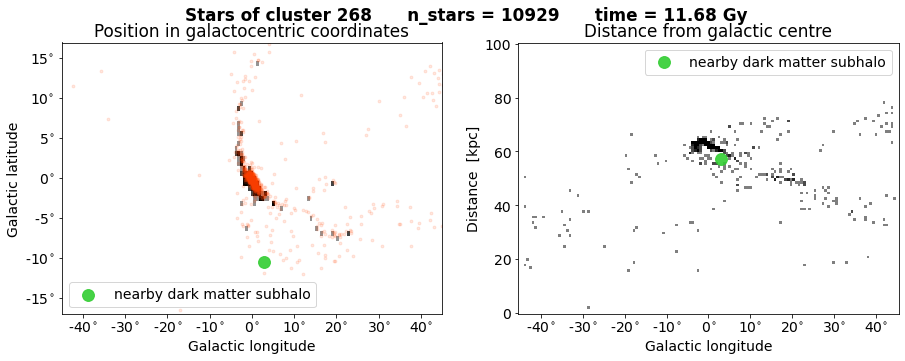

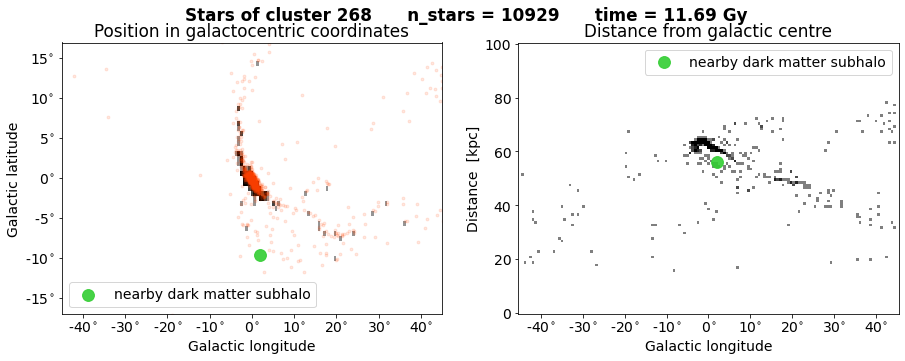

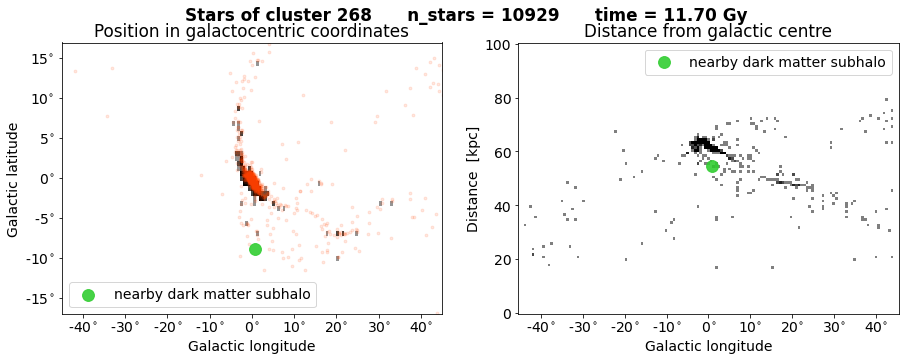

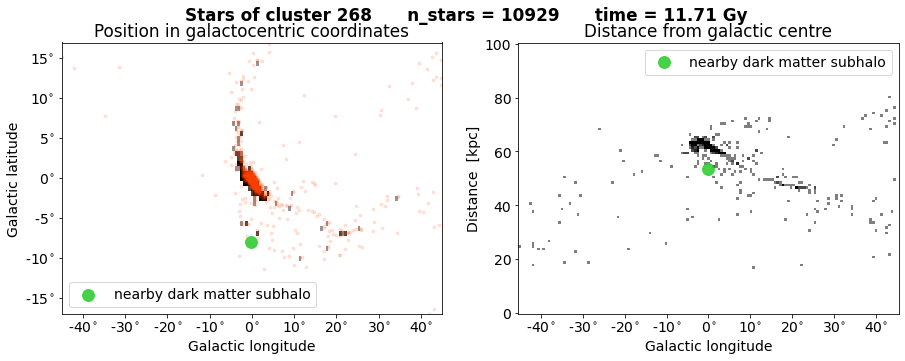

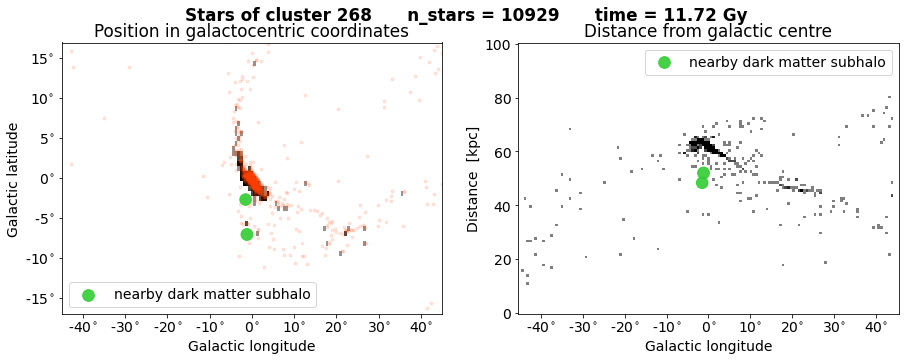

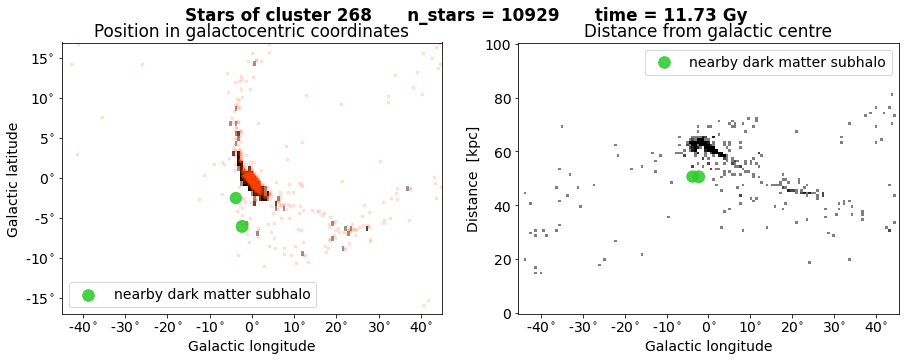

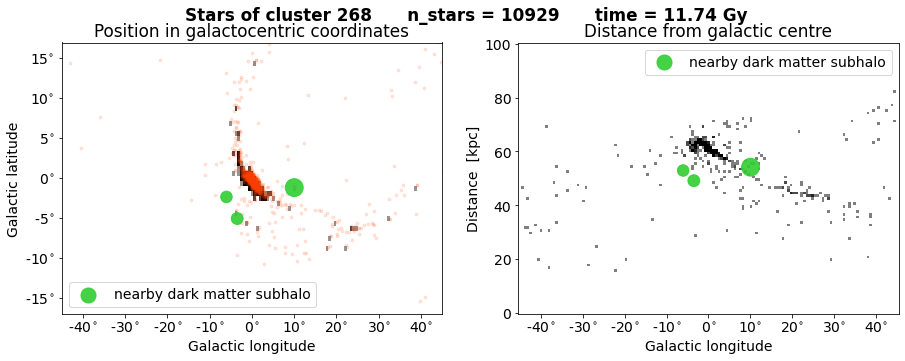

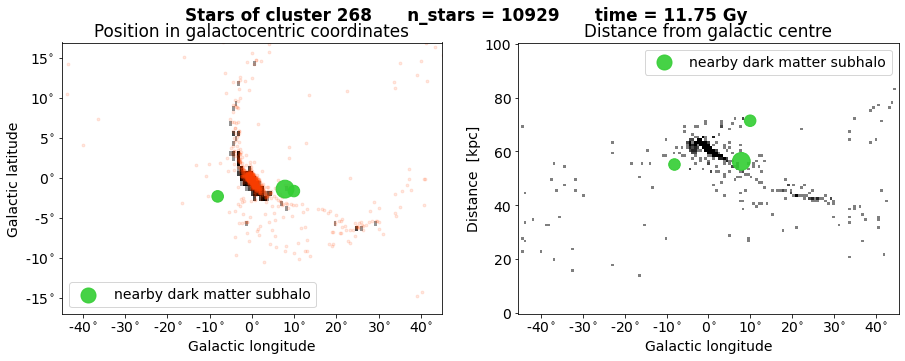

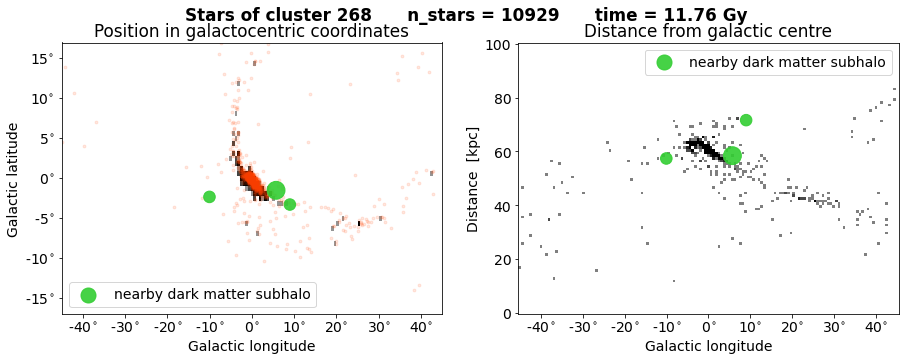

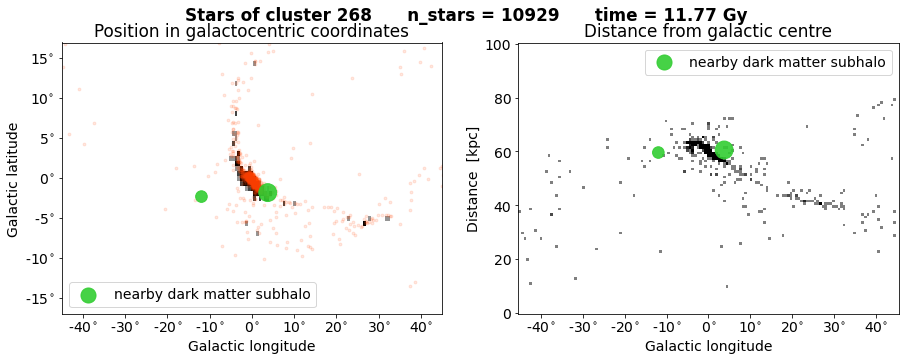

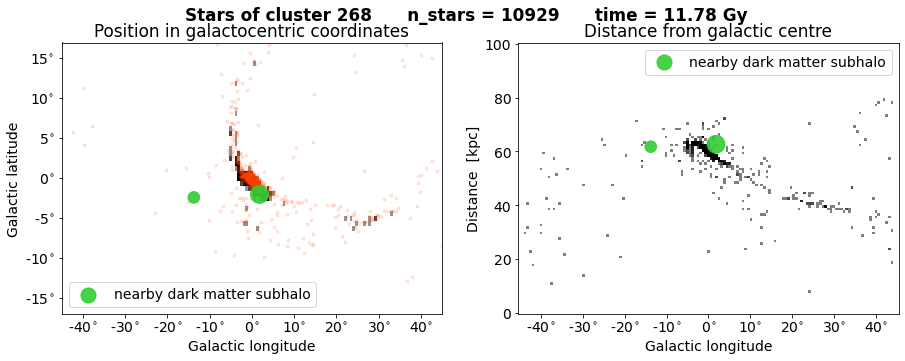

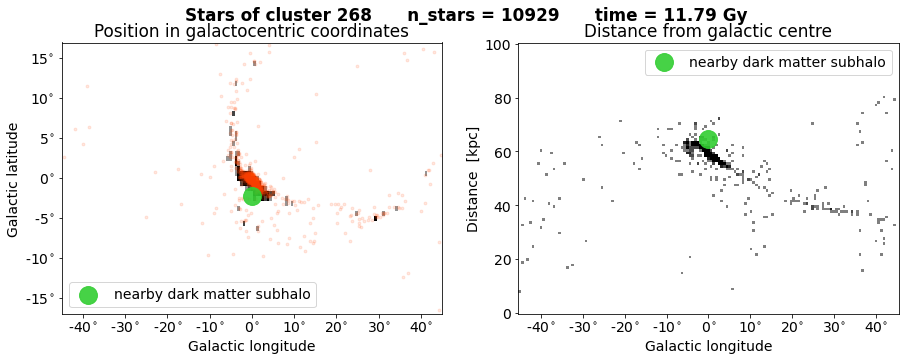

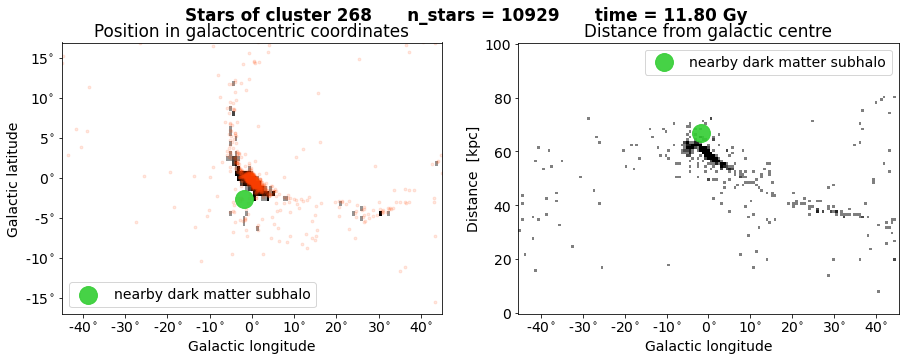

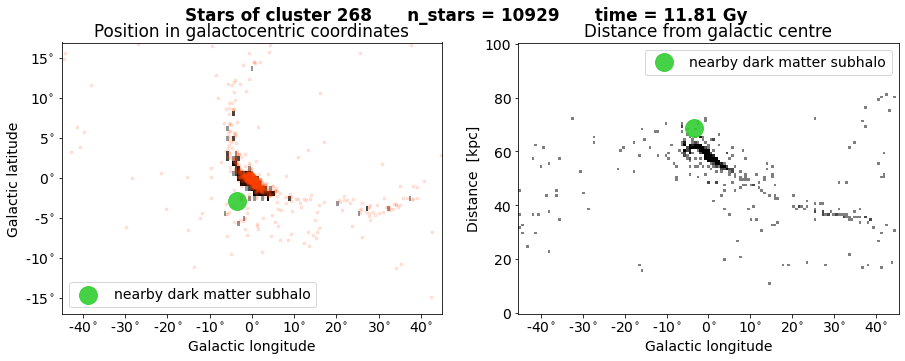

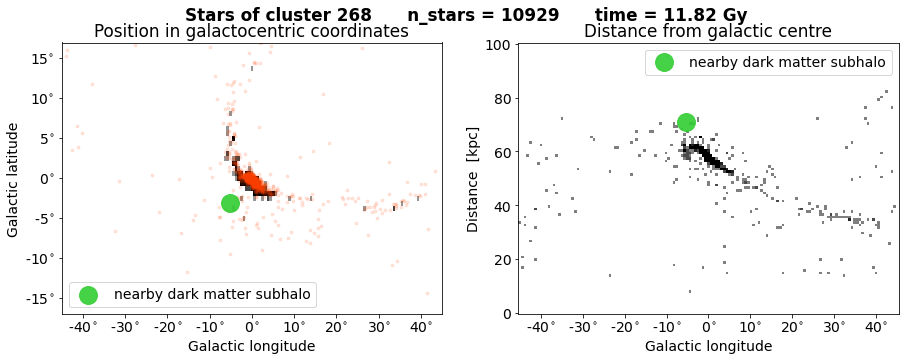

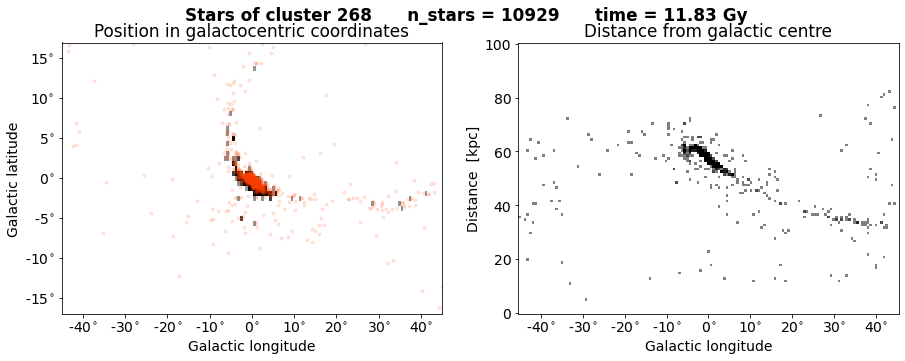

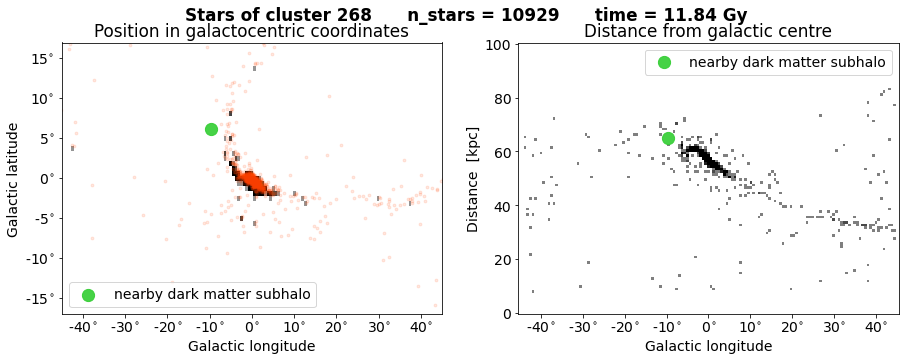

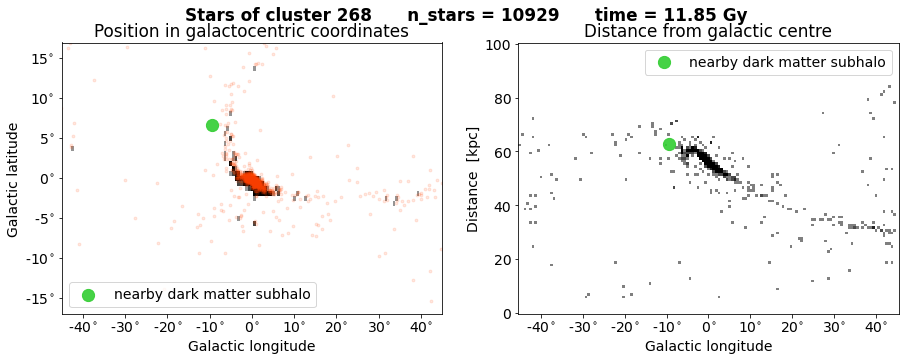

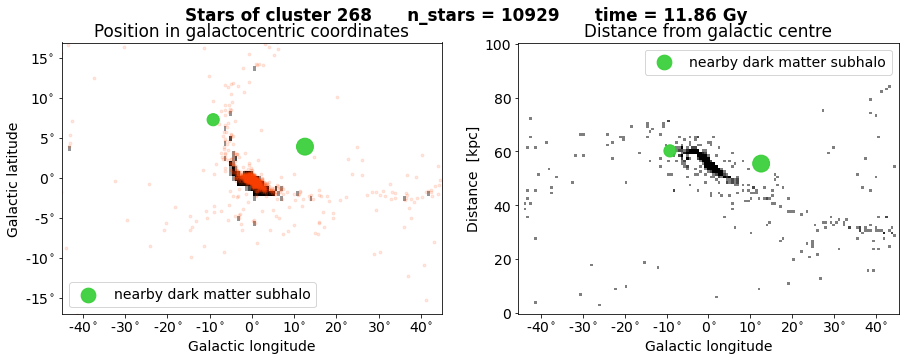

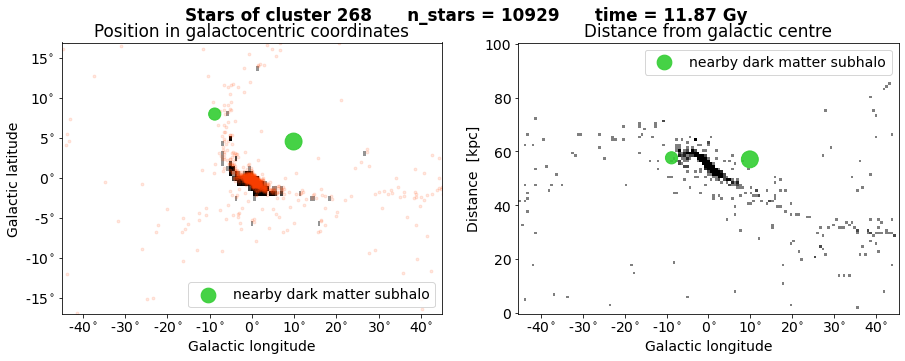

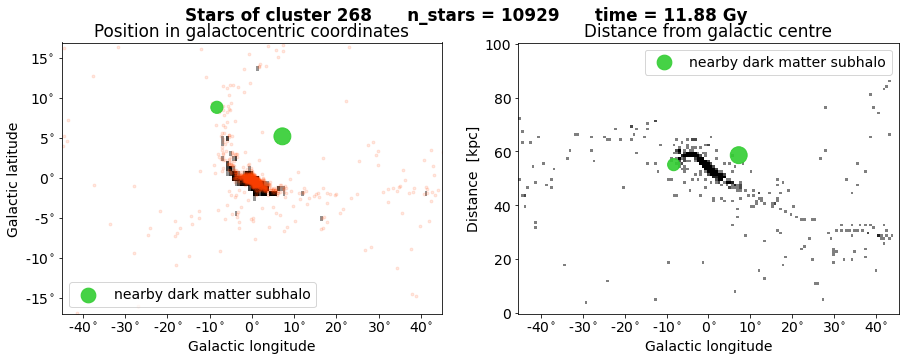

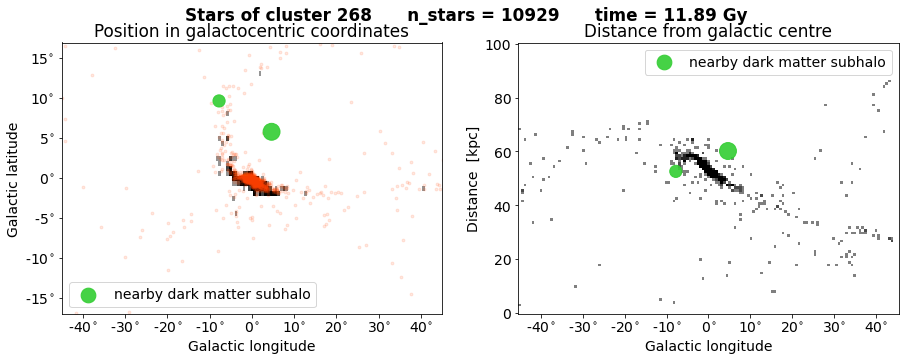

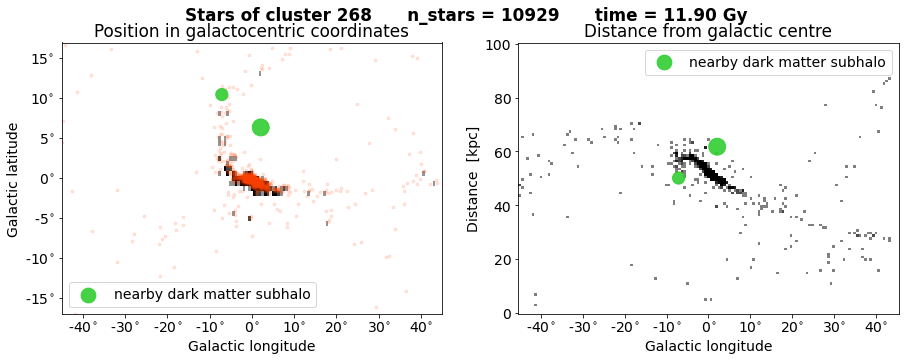

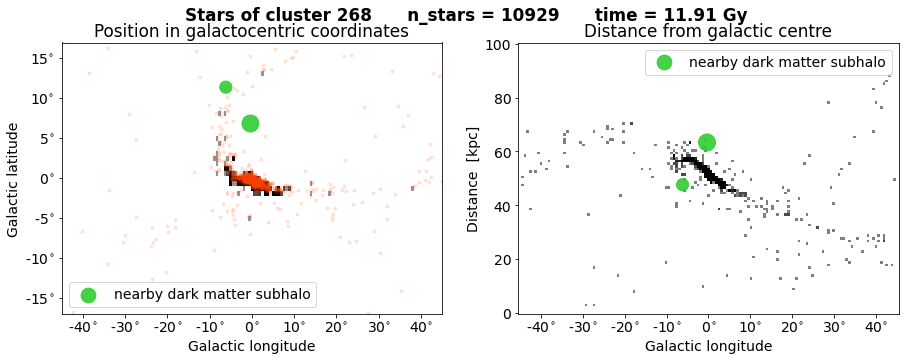

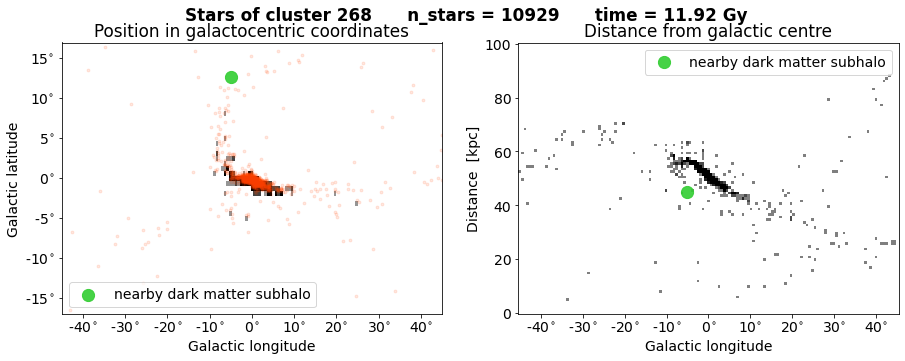

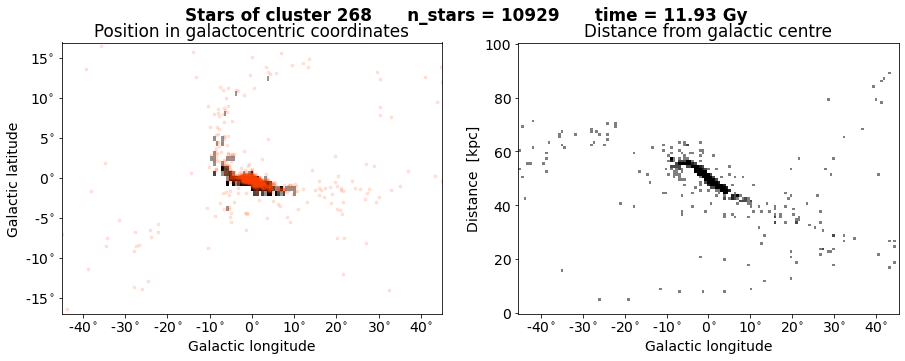

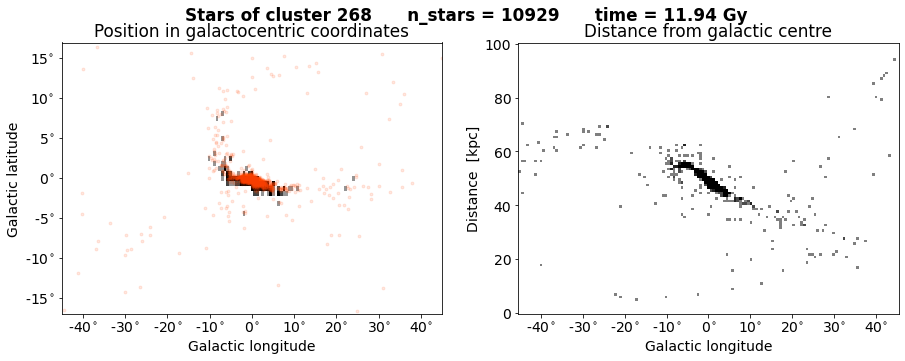

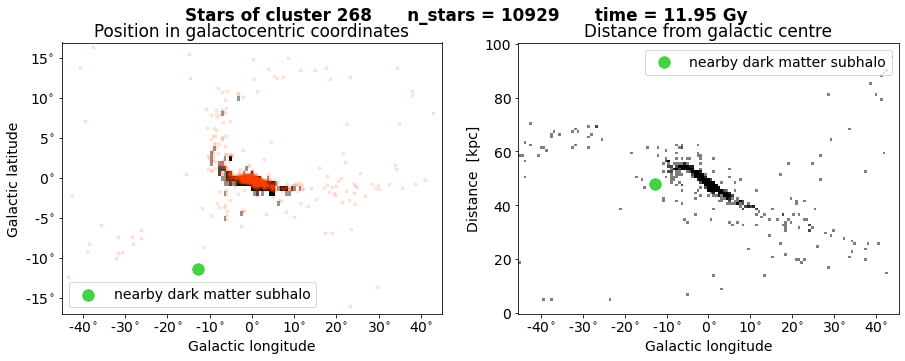

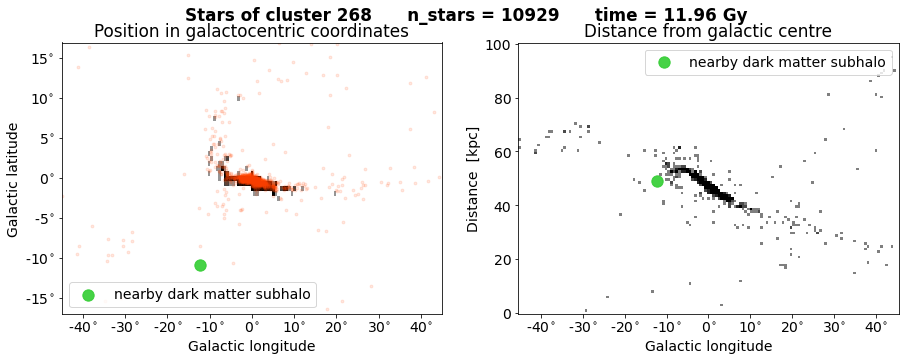

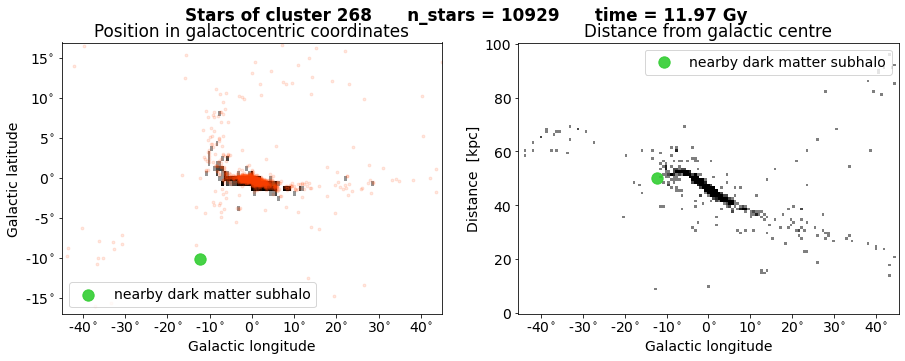

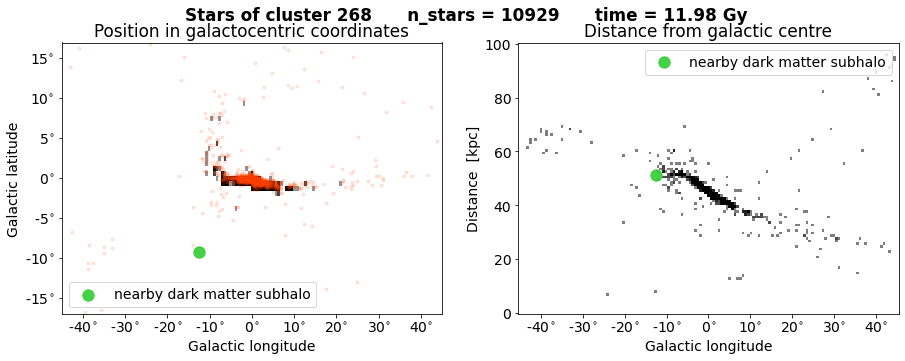

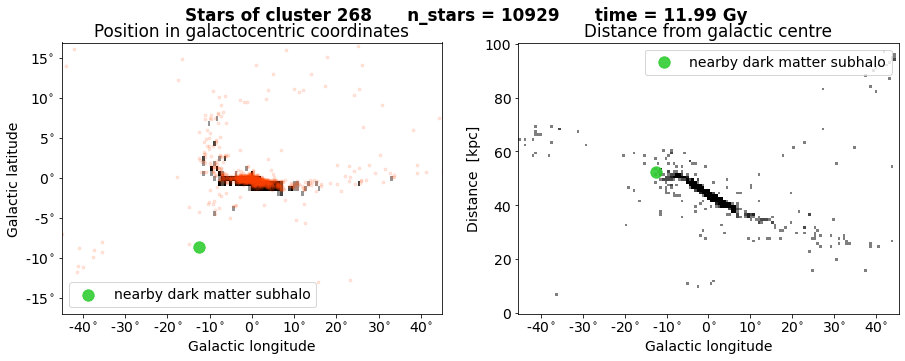

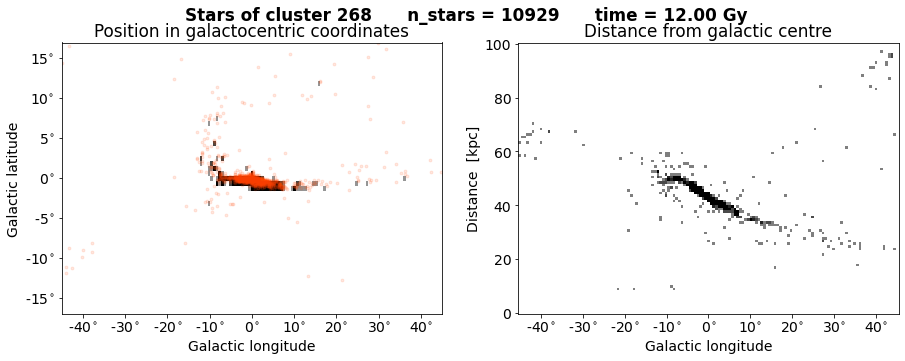

In [43]:
for t in sorted(d.keys(), reverse=False):

    select = (d[t]['ics'] == cluster)

    cluster_x = d[t]['xc'][cluster]
    cluster_y = d[t]['yc'][cluster]
    cluster_z = d[t]['zc'][cluster]
    cluster_r = np.array([cluster_x, cluster_y, cluster_z])

    cluster_vx = d[t]['vxc'][cluster]
    cluster_vy = d[t]['vyc'][cluster]
    cluster_vz = d[t]['vzc'][cluster]
    cluster_v = np.array([cluster_vx, cluster_vy, cluster_vz])

    cluster_L = np.cross(cluster_r, cluster_v)

    transform = build_triple_rotation_matrix(ref_r=cluster_r, ref_L=cluster_L)

    new_cluster_r = transform @ cluster_r
    new_cluster_L = transform @ cluster_L

    new_cluster_Lx = new_cluster_L[0]
    new_cluster_Ly = new_cluster_L[1]
    new_cluster_Lz = new_cluster_L[2]

    ####
    stars_d = d[t]['ds'][select]
    ####

    stars_x = d[t]['xs'][select]
    stars_y = d[t]['ys'][select]
    stars_z = d[t]['zs'][select]

    stars_vx = d[t]['vxs'][select]
    stars_vy = d[t]['vys'][select]
    stars_vz = d[t]['vzs'][select]

    new_stars_Lx = []
    new_stars_Ly = []
    new_stars_Lz = []

    new_stars_x = []
    new_stars_y = []
    new_stars_z = []

    for i in range(len(stars_x)):

        star_x = stars_x[i]
        star_y = stars_y[i]
        star_z = stars_z[i]
        star_r = [star_x, star_y, star_z]

        star_vx = stars_vx[i]
        star_vy = stars_vy[i]
        star_vz = stars_vz[i]
        star_v = [star_vx, star_vy, star_vz]

        star_L = np.cross(star_r, star_v)
        new_star_L = transform @ star_L

        new_stars_Lx.append(new_star_L[0])
        new_stars_Ly.append(new_star_L[1])
        new_stars_Lz.append(new_star_L[2])

        new_star_r = transform @ star_r

        new_stars_x.append(new_star_r[0])
        new_stars_y.append(new_star_r[1])
        new_stars_z.append(new_star_r[2])

    new_stars_Lx = np.array(new_stars_Lx)
    new_stars_Ly = np.array(new_stars_Ly)
    new_stars_Lz = np.array(new_stars_Lz)

    new_stars_x = np.array(new_stars_x)
    new_stars_y = np.array(new_stars_y)
    new_stars_z = np.array(new_stars_z)

    new_stars_delta_Lx = new_stars_Lx - new_cluster_Lx
    new_stars_delta_Ly = new_stars_Ly - new_cluster_Ly
    new_stars_delta_Lz = new_stars_Lz - new_cluster_Lz

    new_stars_L_perp = np.sqrt((new_stars_delta_Lx) ** 2 + (new_stars_delta_Ly) ** 2)

    new_stars_rho = np.sqrt(new_stars_x ** 2 + new_stars_y ** 2 + new_stars_z ** 2)

    # longs and lats formulae taken from previous notebook
    stars_longitudes = np.arctan2(new_stars_y, new_stars_x)
    stars_latitudes = np.arcsin(new_stars_z / new_stars_rho)

    
    new_halos_x = []
    new_halos_y = []
    new_halos_z = []
    
    halo_mass = []
    
    for i in range(len(d[t]['halom'])):

        mass = d[t]['halom'][i]

        if mass >= halo_mass_threshold:

            delta_x = d[t]['halox'][i] - cluster_d[t]['out_x_median']
            delta_y = d[t]['haloy'][i] - cluster_d[t]['out_y_median']
            delta_z = d[t]['haloz'][i] - cluster_d[t]['out_z_median']

            dist = np.sqrt(delta_x ** 2 + delta_y ** 2 + delta_z ** 2)

            if dist <= distance_threshold_for_plot:
                
                halo_x = d[t]['halox'][i]
                halo_y = d[t]['haloy'][i]
                halo_z = d[t]['haloz'][i]

                halo_r = np.array([halo_x, halo_y, halo_z])

                new_halo_r = transform @ halo_r
                
                new_halos_x.append(new_halo_r[0])
                new_halos_y.append(new_halo_r[1])
                new_halos_z.append(new_halo_r[2])
                
                halo_mass.append(mass)
    
    new_halos_x = np.array(new_halos_x)
    new_halos_y = np.array(new_halos_y)
    new_halos_z = np.array(new_halos_z)
    
    new_halos_rho = np.sqrt(new_halos_x ** 2 + new_halos_y ** 2 + new_halos_z ** 2)

    halos_longitudes = np.arctan2(new_halos_y, new_halos_x)
    halos_latitudes = np.arcsin(new_halos_z / new_halos_rho)
    
    
    
    plt.figure(figsize=(15, 5))
    plt.rc('font', size=14)


    lon_v, lat_v = np.meshgrid(lon, lat)

    D = np.zeros((ng_lat + 1, ng_lon + 1))

    for star in range(len(stars_longitudes)):

        if (-lon_max <= stars_longitudes[star] <= lon_max) and (-lat_max <= stars_latitudes[star] <= lat_max):

            ix = int(round((stars_longitudes[star] + lon_max) / dg)) 
            iy = int(round((stars_latitudes[star] + lat_max) / dg)) 
            D[iy, ix] += 1

    Ds = np.sqrt(D)

    plt.subplot(1,2,1)
    plt.pcolormesh(lon_v, lat_v, Ds, cmap='binary', vmin=1, vmax=2)
    plt.scatter(stars_longitudes, stars_latitudes, s=8, c='orangered', alpha=0.12)
    
    size = 125 * (np.log10(halo_mass) - 6)
    plt.scatter(halos_longitudes, halos_latitudes, s=size, c='limegreen', alpha=0.9, 
                label='nearby dark matter subhalo')

    plt.xlim(-lon_max, lon_max)
    plt.ylim(-17 * u.deg.to(u.rad), 17 * u.deg.to(u.rad))

    plt.xticks(ticks=lon_range_deg * u.deg.to(u.rad), labels=lon_range_deg_str)
    plt.yticks(ticks=lat_range_deg * u.deg.to(u.rad), labels=lat_range_deg_str)
    
    if halo_mass:
        plt.legend()

    plt.xlabel('Galactic longitude')
    plt.ylabel('Galactic latitude')
    plt.title('Position in galactocentric coordinates')


    ###
    #d_max = max(stars_d) #/ zoom
    d_max = 100
    d_min = 0
    ng_d = int((d_max - d_min) * 1 + 1)

    d_linspace = np.linspace(d_min, d_max, ng_d + 1) 
    lon_v, d_v = np.meshgrid(lon, d_linspace)

    D = np.zeros((ng_d + 1, ng_lon + 1))

    for star in range(len(stars_longitudes)):

        if (-lon_max <= stars_longitudes[star] <= lon_max) \
    and (d_min <= stars_d[star] <= d_max):

            ix = int(round((stars_longitudes[star] + lon_max) / dg)) 
            iy = int(round((stars_d[star] + -d_min) * 1)) 

            D[iy, ix] += 1

    Ds = np.sqrt(D)
    ###

    plt.subplot(1,2,2)
    plt.pcolormesh(lon_v, d_v, Ds, cmap='binary', vmin=0, vmax=2)
    plt.scatter(halos_longitudes, new_halos_rho, s=size, c='limegreen', alpha=0.9, 
            label='nearby dark matter subhalo')

    plt.xticks(ticks=lon_range_deg * u.deg.to(u.rad), labels=lon_range_deg_str)
    
    if halo_mass:
        plt.legend()
    
    plt.xlabel('Galactic longitude')
    plt.ylabel('Distance  [kpc]')
    plt.title('Distance from galactic centre')

    
    timestamp = d[t]['time']
    
    plt.suptitle('Stars of cluster ' + str(cluster) + ' ' * 6 + 'n_stars = ' + str(len(stars_x))
                 + ' ' * 6 + 'time = %.2f Gy' % timestamp, fontweight='bold')
    plt.show()

print('\n\n')

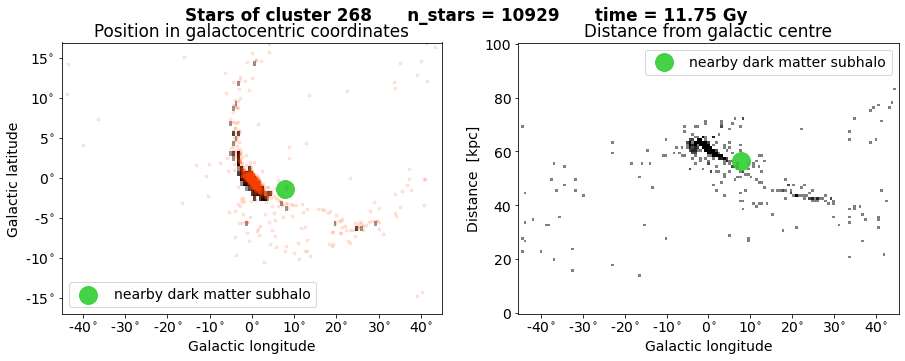

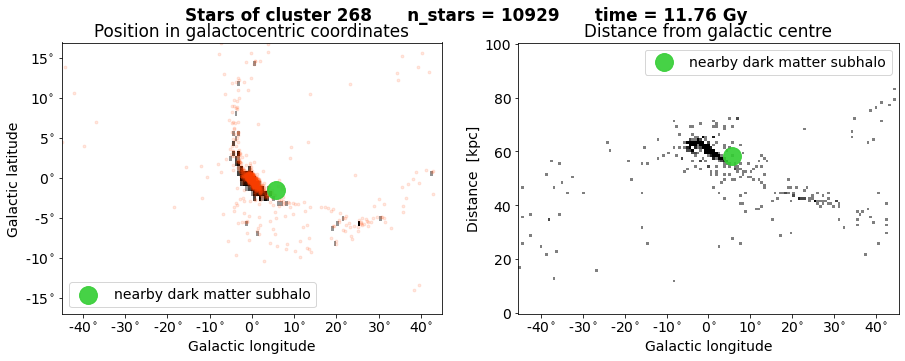

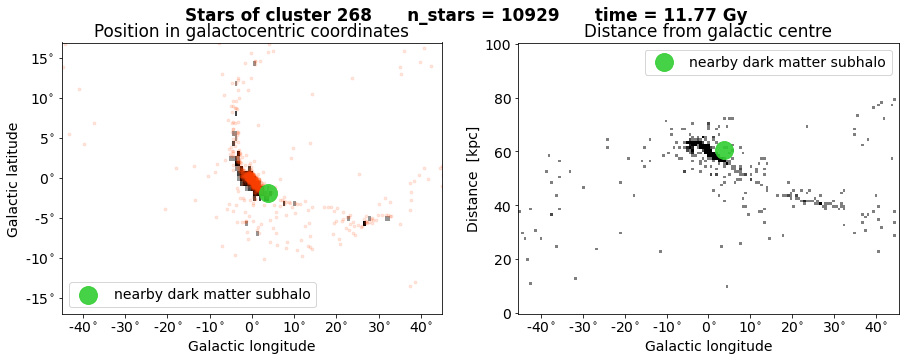

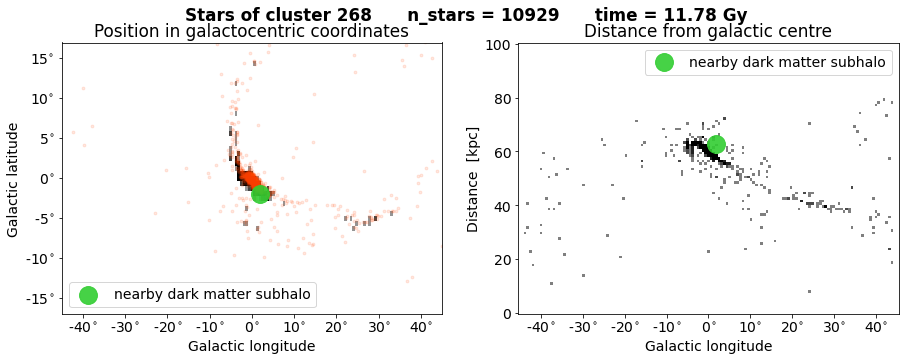

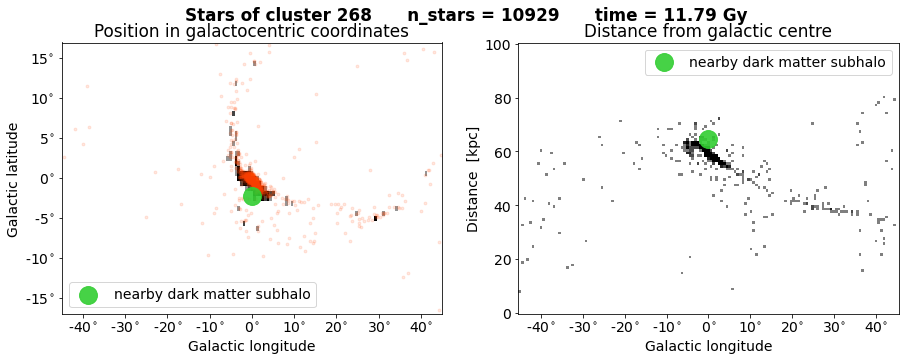

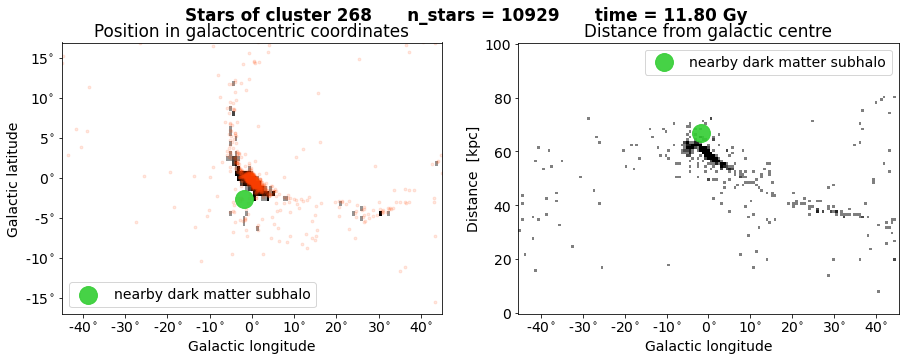

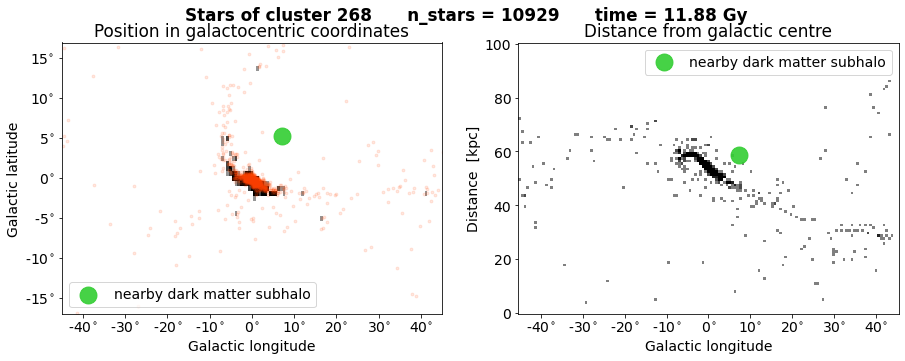

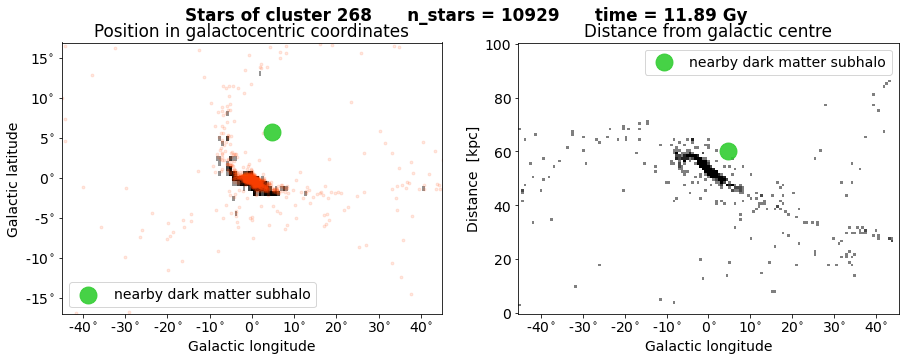

In [44]:
distance_threshold_for_plot = 10


for t in sorted(d.keys(), reverse=False):

    select = (d[t]['ics'] == cluster)

    cluster_x = d[t]['xc'][cluster]
    cluster_y = d[t]['yc'][cluster]
    cluster_z = d[t]['zc'][cluster]
    cluster_r = np.array([cluster_x, cluster_y, cluster_z])

    cluster_vx = d[t]['vxc'][cluster]
    cluster_vy = d[t]['vyc'][cluster]
    cluster_vz = d[t]['vzc'][cluster]
    cluster_v = np.array([cluster_vx, cluster_vy, cluster_vz])

    cluster_L = np.cross(cluster_r, cluster_v)

    transform = build_triple_rotation_matrix(ref_r=cluster_r, ref_L=cluster_L)

    new_cluster_r = transform @ cluster_r
    new_cluster_L = transform @ cluster_L

    new_cluster_Lx = new_cluster_L[0]
    new_cluster_Ly = new_cluster_L[1]
    new_cluster_Lz = new_cluster_L[2]

    ####
    stars_d = d[t]['ds'][select]
    ####

    stars_x = d[t]['xs'][select]
    stars_y = d[t]['ys'][select]
    stars_z = d[t]['zs'][select]

    stars_vx = d[t]['vxs'][select]
    stars_vy = d[t]['vys'][select]
    stars_vz = d[t]['vzs'][select]

    new_stars_Lx = []
    new_stars_Ly = []
    new_stars_Lz = []

    new_stars_x = []
    new_stars_y = []
    new_stars_z = []

    for i in range(len(stars_x)):

        star_x = stars_x[i]
        star_y = stars_y[i]
        star_z = stars_z[i]
        star_r = [star_x, star_y, star_z]

        star_vx = stars_vx[i]
        star_vy = stars_vy[i]
        star_vz = stars_vz[i]
        star_v = [star_vx, star_vy, star_vz]

        star_L = np.cross(star_r, star_v)
        new_star_L = transform @ star_L

        new_stars_Lx.append(new_star_L[0])
        new_stars_Ly.append(new_star_L[1])
        new_stars_Lz.append(new_star_L[2])

        new_star_r = transform @ star_r

        new_stars_x.append(new_star_r[0])
        new_stars_y.append(new_star_r[1])
        new_stars_z.append(new_star_r[2])

    new_stars_Lx = np.array(new_stars_Lx)
    new_stars_Ly = np.array(new_stars_Ly)
    new_stars_Lz = np.array(new_stars_Lz)

    new_stars_x = np.array(new_stars_x)
    new_stars_y = np.array(new_stars_y)
    new_stars_z = np.array(new_stars_z)

    new_stars_delta_Lx = new_stars_Lx - new_cluster_Lx
    new_stars_delta_Ly = new_stars_Ly - new_cluster_Ly
    new_stars_delta_Lz = new_stars_Lz - new_cluster_Lz

    new_stars_L_perp = np.sqrt((new_stars_delta_Lx) ** 2 + (new_stars_delta_Ly) ** 2)

    new_stars_rho = np.sqrt(new_stars_x ** 2 + new_stars_y ** 2 + new_stars_z ** 2)

    # longs and lats formulae taken from previous notebook
    stars_longitudes = np.arctan2(new_stars_y, new_stars_x)
    stars_latitudes = np.arcsin(new_stars_z / new_stars_rho)

    
    new_halos_x = []
    new_halos_y = []
    new_halos_z = []
    
    halo_mass = []
    
    for i in range(len(d[t]['halom'])):

        mass = d[t]['halom'][i]

        if mass >= halo_mass_threshold:

            delta_x = d[t]['halox'][i] - cluster_d[t]['out_x_median']
            delta_y = d[t]['haloy'][i] - cluster_d[t]['out_y_median']
            delta_z = d[t]['haloz'][i] - cluster_d[t]['out_z_median']

            dist = np.sqrt(delta_x ** 2 + delta_y ** 2 + delta_z ** 2)

            if dist <= distance_threshold_for_plot:
                
                halo_x = d[t]['halox'][i]
                halo_y = d[t]['haloy'][i]
                halo_z = d[t]['haloz'][i]

                halo_r = np.array([halo_x, halo_y, halo_z])

                new_halo_r = transform @ halo_r
                
                new_halos_x.append(new_halo_r[0])
                new_halos_y.append(new_halo_r[1])
                new_halos_z.append(new_halo_r[2])
                
                halo_mass.append(mass)
    
    if not halo_mass:
        continue
    
    new_halos_x = np.array(new_halos_x)
    new_halos_y = np.array(new_halos_y)
    new_halos_z = np.array(new_halos_z)
    
    new_halos_rho = np.sqrt(new_halos_x ** 2 + new_halos_y ** 2 + new_halos_z ** 2)

    halos_longitudes = np.arctan2(new_halos_y, new_halos_x)
    halos_latitudes = np.arcsin(new_halos_z / new_halos_rho)
    
    
    
    plt.figure(figsize=(15, 5))
    plt.rc('font', size=14)


    lon_v, lat_v = np.meshgrid(lon, lat)

    D = np.zeros((ng_lat + 1, ng_lon + 1))

    for star in range(len(stars_longitudes)):

        if (-lon_max <= stars_longitudes[star] <= lon_max) and (-lat_max <= stars_latitudes[star] <= lat_max):

            ix = int(round((stars_longitudes[star] + lon_max) / dg)) 
            iy = int(round((stars_latitudes[star] + lat_max) / dg)) 
            D[iy, ix] += 1

    Ds = np.sqrt(D)

    plt.subplot(1,2,1)
    plt.pcolormesh(lon_v, lat_v, Ds, cmap='binary', vmin=1, vmax=2)
    plt.scatter(stars_longitudes, stars_latitudes, s=8, c='orangered', alpha=0.12)
    
    size = 125 * (np.log10(halo_mass) - 6)
    plt.scatter(halos_longitudes, halos_latitudes, s=size, c='limegreen', alpha=0.9, 
                label='nearby dark matter subhalo')

    plt.xlim(-lon_max, lon_max)
    plt.ylim(-17 * u.deg.to(u.rad), 17 * u.deg.to(u.rad))

    plt.xticks(ticks=lon_range_deg * u.deg.to(u.rad), labels=lon_range_deg_str)
    plt.yticks(ticks=lat_range_deg * u.deg.to(u.rad), labels=lat_range_deg_str)
    
    if halo_mass:
        plt.legend()

    plt.xlabel('Galactic longitude')
    plt.ylabel('Galactic latitude')
    plt.title('Position in galactocentric coordinates')


    ###
    #d_max = max(stars_d) #/ zoom
    d_max = 100
    d_min = 0
    ng_d = int((d_max - d_min) * 1 + 1)

    d_linspace = np.linspace(d_min, d_max, ng_d + 1) 
    lon_v, d_v = np.meshgrid(lon, d_linspace)

    D = np.zeros((ng_d + 1, ng_lon + 1))

    for star in range(len(stars_longitudes)):

        if (-lon_max <= stars_longitudes[star] <= lon_max) \
    and (d_min <= stars_d[star] <= d_max):

            ix = int(round((stars_longitudes[star] + lon_max) / dg)) 
            iy = int(round((stars_d[star] + -d_min) * 1)) 

            D[iy, ix] += 1

    Ds = np.sqrt(D)
    ###

    plt.subplot(1,2,2)
    plt.pcolormesh(lon_v, d_v, Ds, cmap='binary', vmin=0, vmax=2)
    plt.scatter(halos_longitudes, new_halos_rho, s=size, c='limegreen', alpha=0.9, 
            label='nearby dark matter subhalo')

    plt.xticks(ticks=lon_range_deg * u.deg.to(u.rad), labels=lon_range_deg_str)
    
    if halo_mass:
        plt.legend()
    
    plt.xlabel('Galactic longitude')
    plt.ylabel('Distance  [kpc]')
    plt.title('Distance from galactic centre')

    
    timestamp = d[t]['time']
    
    plt.suptitle('Stars of cluster ' + str(cluster) + ' ' * 6 + 'n_stars = ' + str(len(stars_x))
                 + ' ' * 6 + 'time = %.2f Gy' % timestamp, fontweight='bold')
    plt.show()

print('\n\n')